# Retail Price Optimization

In [ ]:
# Research questions in this price optimization project:

# What are the key factors influencing product demand and pricing?
# Analyzing variables like competitor pricing, product features, freight costs, and customer behavior.

# How does price elasticity impact demand?
# Identifying how changes in unit prices affect quantities sold and overall revenue.

# What are the optimal pricing strategies for maximizing revenue and profit?
# Using simulations and modeling to explore revenue-maximizing price points.

# How can advanced techniques like utility optimization and fuzzy logic enhance pricing decisions?
# Exploring how these methods adjust prices based on factors like inventory, demand, and competition.

# What role do competitor prices and customer segmentation play in dynamic pricing?
# Using competitor data and customer segmentation to refine pricing strategies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import zipfile

In [2]:
# Extract the ZIP file
zip_file_path = 'Retail Price Optimization.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('retail_price_data')

# Load the dataset
csv_file_path = 'retail_price_data/retail_price.csv'
data = pd.read_csv(csv_file_path)

print("Dataset Overview:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Overview:
  product_id product_category_name  month_year  qty  total_price  \
0       bed1        bed_bath_table  01-05-2017    1        45.95   
1       bed1        bed_bath_table  01-06-2017    3       137.85   
2       bed1        bed_bath_table  01-07-2017    6       275.70   
3       bed1        bed_bath_table  01-08-2017    4       183.80   
4       bed1        bed_bath_table  01-09-2017    2        91.90   

   freight_price  unit_price  product_name_lenght  product_description_lenght  \
0      15.100000       45.95                   39                         161   
1      12.933333       45.95                   39                         161   
2      14.840000       45.95                   39                         161   
3      14.287500       45.95                   39                         161   
4      15.100000       45.95                   39                         161   

   product_photos_qty  ...  comp_1  ps1        fp1      comp_2  ps2  \
0              

In [3]:
# Ensure 'unit_price' is a single-column Series
if isinstance(data['unit_price'], pd.DataFrame):
    print("unit_price is a DataFrame, selecting the first column explicitly.")
    data['unit_price'] = data['unit_price'].iloc[:, 0]  # Select the first column

# Confirm the fix
print(f"unit_price type after fix: {type(data['unit_price'])}")
print(f"unit_price shape after fix: {data['unit_price'].shape}")

unit_price type after fix: <class 'pandas.core.series.Series'>
unit_price shape after fix: (676,)


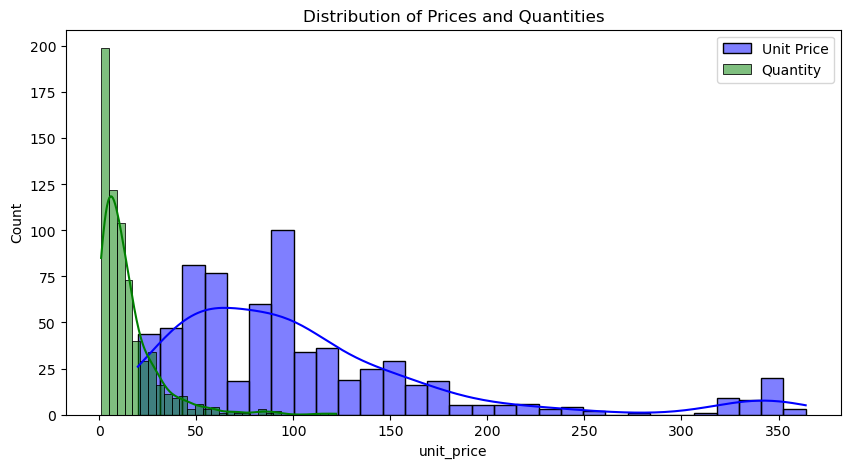

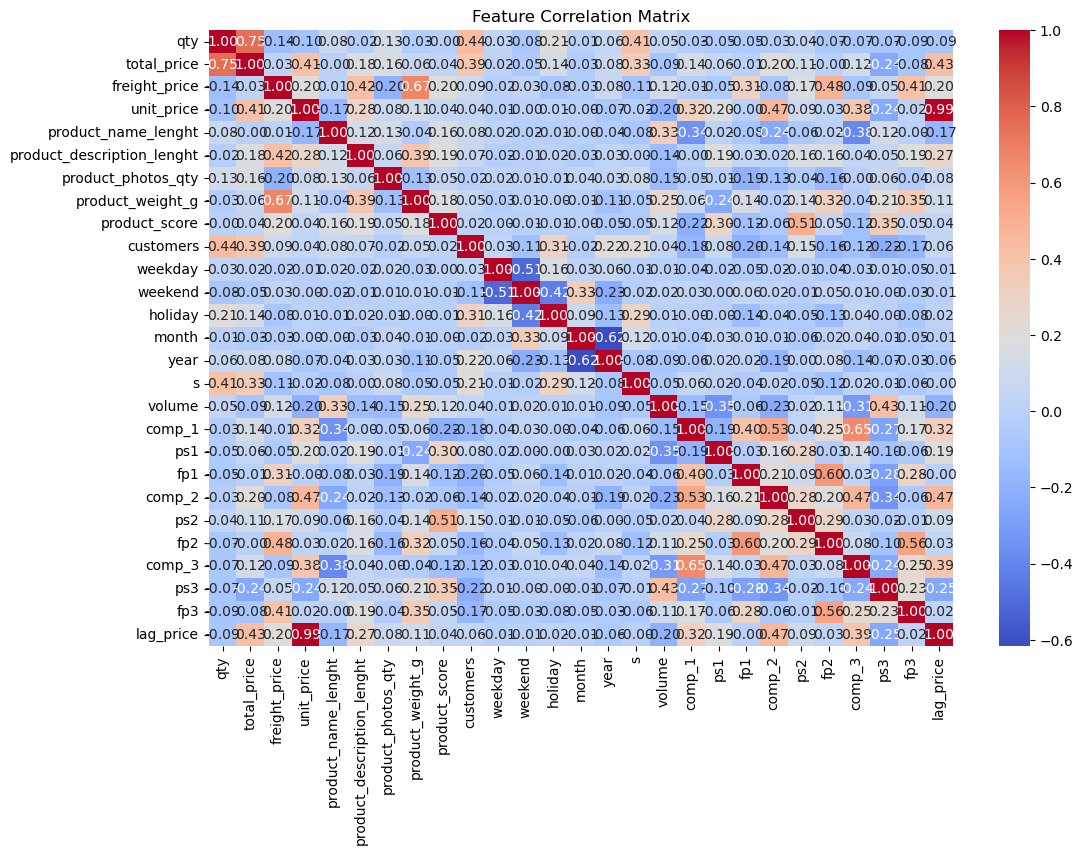

In [4]:
# Step 2: Visualize Key Features
def visualize_data(data):
    plt.figure(figsize=(10, 5))
    sns.histplot(data['unit_price'], kde=True, color='blue', bins=30, label='Unit Price')
    sns.histplot(data['qty'], kde=True, color='green', bins=30, label='Quantity')
    plt.title("Distribution of Prices and Quantities")
    plt.legend()
    plt.show()

    # Correlation Heatmap
    numerical_features = data.select_dtypes(include=[np.number])
    plt.figure(figsize=(12, 8))
    sns.heatmap(numerical_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Feature Correlation Matrix")
    plt.show()

visualize_data(data)

In [7]:
# Step 3: Feature Engineering with Debugging and Fixes
scaler = MinMaxScaler()
numeric_features = ['unit_price', 'freight_price', 'comp_1', 'comp_2', 'comp_3']

# Debugging: Check initial numeric features
print("Initial Numeric Features:")
print(data[numeric_features].head())

# Ensure 'unit_price' and 'freight_price' are single-column Series
for col in ['unit_price', 'freight_price']:
    if isinstance(data[col], pd.DataFrame):
        print(f"{col} is a DataFrame, selecting the first column explicitly.")
        data[col] = data[col].iloc[:, 0]  # Select the first column explicitly

# Debugging: Confirm fixes
for col in ['unit_price', 'freight_price']:
    print(f"{col} type after fix: {type(data[col])}, shape: {data[col].shape}")

# Apply scaling
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Debugging: Check scaled numeric features
print("\nScaled Numeric Features:")
print(data[numeric_features].head())

Initial Numeric Features:
   unit_price  unit_price  freight_price  freight_price    comp_1    comp_1  \
0    0.075705    0.075705       0.189318       0.189318  0.212121  0.212121   
1    0.075705    0.075705       0.162153       0.162153  0.212121  0.212121   
2    0.075705    0.075705       0.186058       0.186058  0.212121  0.212121   
3    0.075705    0.075705       0.179131       0.179131  0.212121  0.212121   
4    0.075705    0.075705       0.189318       0.189318  0.212121  0.212121   

     comp_2    comp_2    comp_3    comp_3  
0  0.591212  0.591212  0.110517  0.110517  
1  0.573030  0.573030  0.110517  0.110517  
2  0.560909  0.560909  0.110517  0.110517  
3  0.544272  0.544272  0.110517  0.110517  
4  0.434845  0.434845  0.110517  0.110517  
unit_price is a DataFrame, selecting the first column explicitly.
freight_price is a DataFrame, selecting the first column explicitly.
unit_price type after fix: <class 'pandas.core.frame.DataFrame'>, shape: (676, 2)
freight_price type

In [8]:
# Create Interaction Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Debugging: Check input features for PolynomialFeatures
print("Input Features for PolynomialFeatures:")
print(data[numeric_features].head())

# Fit and transform
interaction_data = poly.fit_transform(data[numeric_features])

# Get feature names directly
interaction_features = poly.get_feature_names_out()  # No need to pass `numeric_features`

# Debugging: Confirm generated feature names
print("\nGenerated Interaction Features:")
print(interaction_features)

# Create DataFrame for interaction features
interaction_df = pd.DataFrame(interaction_data, columns=interaction_features, index=data.index)

# Debugging: Check the shape of interaction features
print(f"Interaction Features Shape: {interaction_df.shape}")

# Concatenate interaction features with the original data
data = pd.concat([data.drop(columns=numeric_features), pd.DataFrame(data[numeric_features], index=data.index), interaction_df], axis=1)

# Debugging: Confirm concatenated data
print(f"Data Shape After Adding Interaction Features: {data.shape}")
print(data.head())

Input Features for PolynomialFeatures:
   unit_price  unit_price  freight_price  freight_price    comp_1    comp_1  \
0    0.075705    0.075705       0.189318       0.189318  0.212121  0.212121   
1    0.075705    0.075705       0.162153       0.162153  0.212121  0.212121   
2    0.075705    0.075705       0.186058       0.186058  0.212121  0.212121   
3    0.075705    0.075705       0.179131       0.179131  0.212121  0.212121   
4    0.075705    0.075705       0.189318       0.189318  0.212121  0.212121   

     comp_2    comp_2    comp_3    comp_3  
0  0.591212  0.591212  0.110517  0.110517  
1  0.573030  0.573030  0.110517  0.110517  
2  0.560909  0.560909  0.110517  0.110517  
3  0.544272  0.544272  0.110517  0.110517  
4  0.434845  0.434845  0.110517  0.110517  

Generated Interaction Features:
['unit_price' 'unit_price' 'freight_price' 'freight_price' 'comp_1'
 'comp_1' 'comp_2' 'comp_2' 'comp_3' 'comp_3' 'unit_price unit_price'
 'unit_price freight_price' 'unit_price freight_pri

In [9]:
# Step 4: Define Target and Features

# Drop identifier and irrelevant columns
irrelevant_columns = ['product_id', 'month_year']  # Add other non-predictive columns
X = data.drop(columns=irrelevant_columns + ['qty', 'total_price'], errors='ignore')

# Debugging: Check for remaining non-numeric columns
non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_columns) > 0:
    print(f"Non-numeric columns detected before conversion: {non_numeric_columns}")

# Convert boolean columns and other non-numeric columns to numeric
for col in non_numeric_columns:
    print(f"Converting non-numeric column '{col}' to numeric.")
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)
    else:
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Validate numeric conversion
non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_columns) > 0:
    raise ValueError(f"The following columns in X are not numeric after conversion: {non_numeric_columns}")

# Debugging: Confirm numeric conversion
print("\nAll columns in X are numeric.")
print(f"Updated Features Shape (X): {X.shape}")

# Define target
y = data['qty']

# Debugging: Confirm shapes
print(f"\nFeatures Shape (X): {X.shape}")
print(f"Target Shape (y): {y.shape}")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Debugging: Confirm splits
print("\nTrain-Test Split Completed!")
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Non-numeric columns detected before conversion: Index(['product_category_name_computers_accessories',
       'product_category_name_consoles_games',
       'product_category_name_cool_stuff',
       'product_category_name_furniture_decor',
       'product_category_name_garden_tools',
       'product_category_name_health_beauty',
       'product_category_name_perfumery',
       'product_category_name_watches_gifts'],
      dtype='object')
Converting non-numeric column 'product_category_name_computers_accessories' to numeric.
Converting non-numeric column 'product_category_name_consoles_games' to numeric.
Converting non-numeric column 'product_category_name_cool_stuff' to numeric.
Converting non-numeric column 'product_category_name_furniture_decor' to numeric.
Converting non-numeric column 'product_category_name_garden_tools' to numeric.
Converting non-numeric column 'product_category_name_health_beauty' to numeric.
Converting non-numeric column 'product_category_name_perfumery' to nume

In [10]:
# Step: Ensure that all one-hot encoded columns are numeric

# Convert all columns in training and testing sets to numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Check for any remaining non-numeric columns
non_numeric_columns_train = X_train.select_dtypes(exclude=[np.number]).columns
non_numeric_columns_test = X_test.select_dtypes(exclude=[np.number]).columns

if len(non_numeric_columns_train) > 0 or len(non_numeric_columns_test) > 0:
    raise ValueError(
        f"Non-numeric columns detected: "
        f"\nTraining: {non_numeric_columns_train.tolist()}"
        f"\nTesting: {non_numeric_columns_test.tolist()}"
    )

# Debugging: Confirm data types in training and testing sets
print("\nTraining Features Data Types After Conversion:")
print(X_train.dtypes.value_counts())

print("\nTesting Features Data Types After Conversion:")
print(X_test.dtypes.value_counts())

# Ensure no missing values after numeric conversion
if X_train.isnull().sum().any() or X_test.isnull().sum().any():
    print("\nWarning: Missing values detected after numeric conversion!")
    print("Training Missing Values:")
    print(X_train.isnull().sum())
    print("Testing Missing Values:")
    print(X_test.isnull().sum())
    raise ValueError("Missing values detected after numeric conversion.")

# Build and Train the Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Debugging: Confirm model training completion
print("\nRandom Forest Model trained successfully!")



Training Features Data Types After Conversion:
float64    84
int64      11
int32       8
Name: count, dtype: int64

Testing Features Data Types After Conversion:
float64    84
int64      11
int32       8
Name: count, dtype: int64

Random Forest Model trained successfully!



Model Evaluation Metrics:
Mean Squared Error (MSE): 99.17
Mean Absolute Error (MAE): 6.23
R² Score: 0.63

Sample of Actual vs Predicted Values:
   Actual  Predicted
0      18      19.20
1      14       9.57
2       1      26.47
3      28      30.94
4       3      21.80
5       9      10.49
6      32      21.84
7      82      59.79
8      12      13.43
9       7       4.61


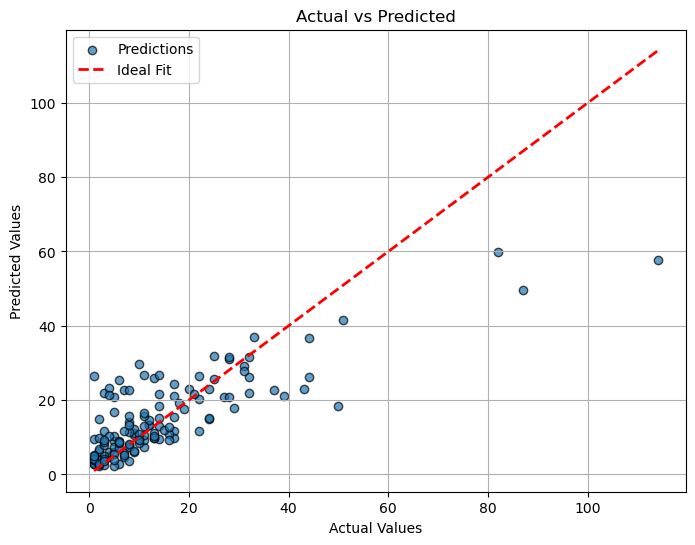

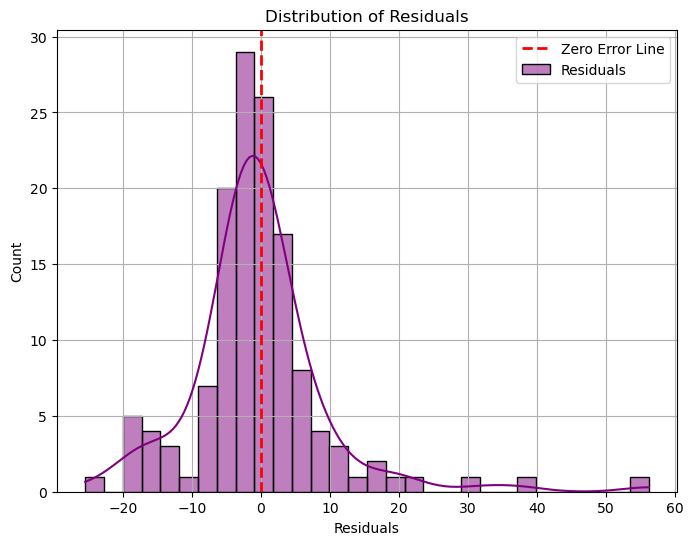

In [11]:
# Step 6: Model Evaluation
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics with descriptive labels
print("\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Debugging: Examine a sample of predictions vs actuals
comparison_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred
})
print("\nSample of Actual vs Predicted Values:")
print(comparison_df.head(10))

# Optional: Visualize Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors="k", label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal Fit")
plt.title("Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

# Optional: Distribution of Residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='purple', label="Residuals")
plt.axvline(0, color='r', linestyle='--', lw=2, label="Zero Error Line")
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.legend()
plt.grid(True)
plt.show()

Iteration 1: Price: 0.00, Total Revenue: 0.54
Iteration 6: Price: 0.10, Total Revenue: 213.18
Iteration 11: Price: 0.20, Total Revenue: 411.40
Iteration 16: Price: 0.31, Total Revenue: 610.54
Iteration 21: Price: 0.41, Total Revenue: 814.90
Iteration 26: Price: 0.51, Total Revenue: 1016.41
Iteration 31: Price: 0.61, Total Revenue: 1219.27
Iteration 36: Price: 0.71, Total Revenue: 1422.03
Iteration 41: Price: 0.82, Total Revenue: 1624.99
Iteration 46: Price: 0.92, Total Revenue: 1829.97
Iteration 50: Price: 1.00, Total Revenue: 1994.73


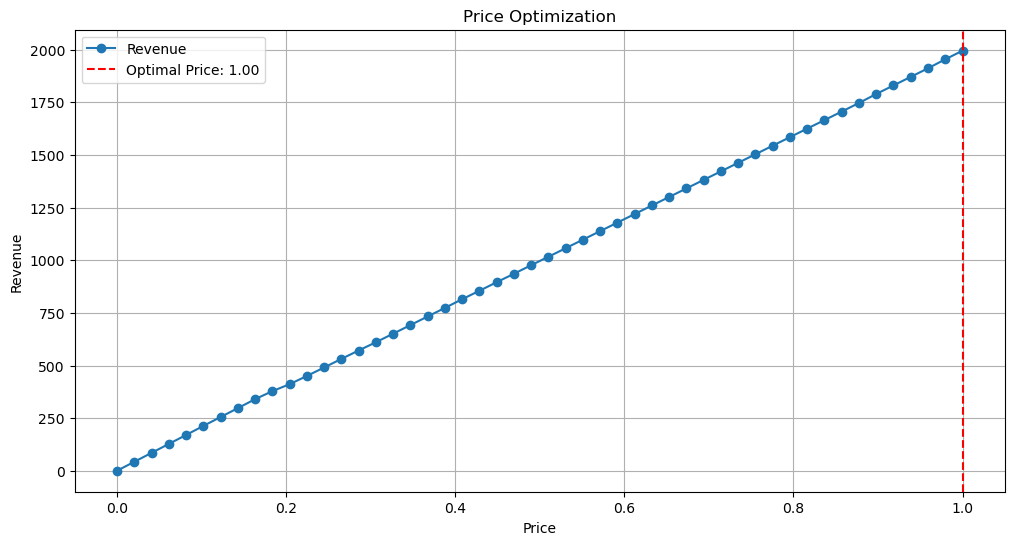


Optimal Price: 1.00
Maximum Revenue: 1994.73


In [17]:
# Step 7: Price Optimization with Debugging and Fixes

# Optimal Pricing Strategies for Maximizing Revenue

# Initialize the list to store simulated revenue data
simulated_revenue = []

# Iterate through price range and calculate revenue
for i, price in enumerate(price_range):
    price = float(price)  # Ensure scalar
    simulated_X_test = X_test.copy()
    simulated_X_test['unit_price'] = price  # Update unit_price with the current scalar price
    
    # Predict simulated quantities
    simulated_qty = model.predict(simulated_X_test)
    
    # Calculate revenue
    total_revenue = np.sum(simulated_qty * price)  # Revenue = price * quantity
    
    # Append price and revenue to the list
    simulated_revenue.append((price, total_revenue))
    
    # Debugging: Log iteration details
    if i % 5 == 0 or i == len(price_range) - 1:  # Log every 5 iterations and the last iteration
        print(f"Iteration {i + 1}: Price: {price:.2f}, Total Revenue: {total_revenue:.2f}")

# Find the optimal price
optimal_price = max(simulated_revenue, key=lambda x: x[1])

# Visualization: Revenue vs. Price
prices, revenues = zip(*simulated_revenue)
plt.figure(figsize=(12, 6))
plt.plot(prices, revenues, marker='o', label="Revenue")
plt.axvline(optimal_price[0], color='red', linestyle='--', label=f"Optimal Price: {optimal_price[0]:.2f}")
plt.title("Price Optimization")
plt.xlabel("Price")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.show()

# Output optimal price and revenue
print(f"\nOptimal Price: {optimal_price[0]:.2f}")
print(f"Maximum Revenue: {optimal_price[1]:.2f}")

In [18]:
# Step 8: Fuzzy Logic for Pricing Adjustment (Final Fix)

# Debugging: Check the original shape of 'unit_price'
print(f"Before fix - unit_price shape: {data['unit_price'].shape}")

# Ensure 'unit_price' is a single-column Series
if isinstance(data['unit_price'], pd.DataFrame):
    print("unit_price is a DataFrame, selecting the first column explicitly.")
    data['unit_price'] = data['unit_price'].iloc[:, 0]

# Check for shape mismatches and align the column
if len(data['unit_price']) != len(data):
    print(f"unit_price shape mismatch detected: {len(data['unit_price'])} values for {len(data)} rows.")
    
    # Attempt to align 'unit_price' with the dataset rows
    try:
        data['unit_price'] = pd.Series(data['unit_price'].values[:len(data)], index=data.index)
        print("unit_price successfully aligned with dataset rows.")
    except Exception as e:
        raise ValueError(f"Failed to align 'unit_price' with dataset rows: {e}")

# Debugging: Confirm the fix
if not isinstance(data['unit_price'], pd.Series):
    raise ValueError("unit_price is not a Series after attempted fix.")

if len(data['unit_price']) != len(data):
    raise ValueError(f"unit_price shape still mismatched: {len(data['unit_price'])} values for {len(data)} rows.")

# Final confirmation of 'unit_price' shape and type
print(f"After fix - unit_price type: {type(data['unit_price'])}, shape: {data['unit_price'].shape}")

Before fix - unit_price shape: (676,)
After fix - unit_price type: <class 'pandas.core.series.Series'>, shape: (676,)


In [19]:
# Step 9: Utility Optimization (Simplified Revenue Maximization)

# Ensure 'freight_price' is a proper Series
if isinstance(data['freight_price'], pd.DataFrame):
    print("freight_price is a DataFrame, selecting the first column explicitly.")
    # Correctly select the first column and overwrite
    data['freight_price'] = data['freight_price'].iloc[:, 0]

# Debugging: Confirm 'freight_price' is now a Series
print(f"freight_price type after fix: {type(data['freight_price'])}")
print(f"freight_price shape after fix: {data['freight_price'].shape}")

# Validate price range
if price_range.size == 0 or price_range.min() <= 0:
    raise ValueError("Invalid price range detected. Ensure it has positive values and is not empty.")

# Debugging: Confirm price range properties
print(f"Price Range: {price_range}")
print(f"Price Range Min: {price_range.min()}, Max: {price_range.max()}, Shape: {price_range.shape}")

# Calculate freight_price mean
try:
    freight_mean = data['freight_price'].mean()
    print(f"freight_price mean (scalar): {freight_mean}")
except Exception as e:
    raise ValueError(f"Error calculating freight_price mean: {e}")

# Check if freight_mean is valid
if np.isnan(freight_mean) or not np.isfinite(freight_mean):
    raise ValueError("freight_price mean is NaN or infinite. Check data preprocessing.")

# Define utility optimization function
def utility_optimization(prices, costs):
    """
    Optimize utility by maximizing the difference between prices and costs.
    :param prices: Array of prices
    :param costs: Cost scalar or array
    :return: Price that maximizes the utility
    """
    utilities = prices - costs
    return prices[np.argmax(utilities)]

# Calculate utility-optimized price
optimal_utility_price = utility_optimization(price_range, freight_mean)

# Debugging: Log the optimal price
print(f"Utility-Optimized Price: {optimal_utility_price:.2f}")

freight_price type after fix: <class 'pandas.core.series.Series'>
freight_price shape after fix: (676,)
Price Range: [2.61551874e-04 2.06643773e-02 4.10672028e-02 6.14700283e-02
 8.18728538e-02 1.02275679e-01 1.22678505e-01 1.43081330e-01
 1.63484156e-01 1.83886981e-01 2.04289807e-01 2.24692632e-01
 2.45095458e-01 2.65498283e-01 2.85901108e-01 3.06303934e-01
 3.26706759e-01 3.47109585e-01 3.67512410e-01 3.87915236e-01
 4.08318061e-01 4.28720887e-01 4.49123712e-01 4.69526538e-01
 4.89929363e-01 5.10332189e-01 5.30735014e-01 5.51137840e-01
 5.71540665e-01 5.91943491e-01 6.12346316e-01 6.32749142e-01
 6.53151967e-01 6.73554792e-01 6.93957618e-01 7.14360443e-01
 7.34763269e-01 7.55166094e-01 7.75568920e-01 7.95971745e-01
 8.16374571e-01 8.36777396e-01 8.57180222e-01 8.77583047e-01
 8.97985873e-01 9.18388698e-01 9.38791524e-01 9.59194349e-01
 9.79597175e-01 1.00000000e+00]
Price Range Min: 0.0002615518744550974, Max: 1.0, Shape: (50,)
freight_price mean (scalar): 0.2593062933946625
Utility-

# Key Questions


Top 10 Features Influencing Demand:
                       Feature  Importance
11                           s    0.293094
5                    customers    0.138986
3             product_weight_g    0.038221
2           product_photos_qty    0.034775
12                      volume    0.022643
18                         fp3    0.021484
16                         fp2    0.020826
0          product_name_lenght    0.017063
50               freight_price    0.017028
1   product_description_lenght    0.014406


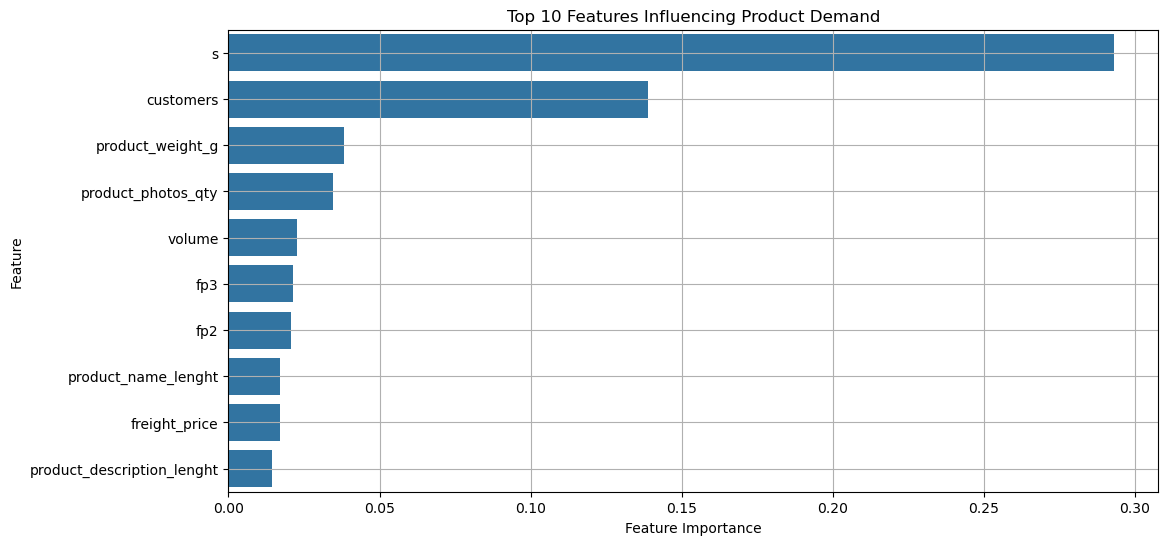

In [20]:
# Key Factors Influencing Product Demand and Pricing

# Use feature importance from the Random Forest model to understand the impact of variables like competitor pricing, product features, 
# freight costs, and customer behavior.

# Extract feature importance from the trained Random Forest model
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("\nTop 10 Features Influencing Demand:")
print(feature_importances.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title("Top 10 Features Influencing Product Demand")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

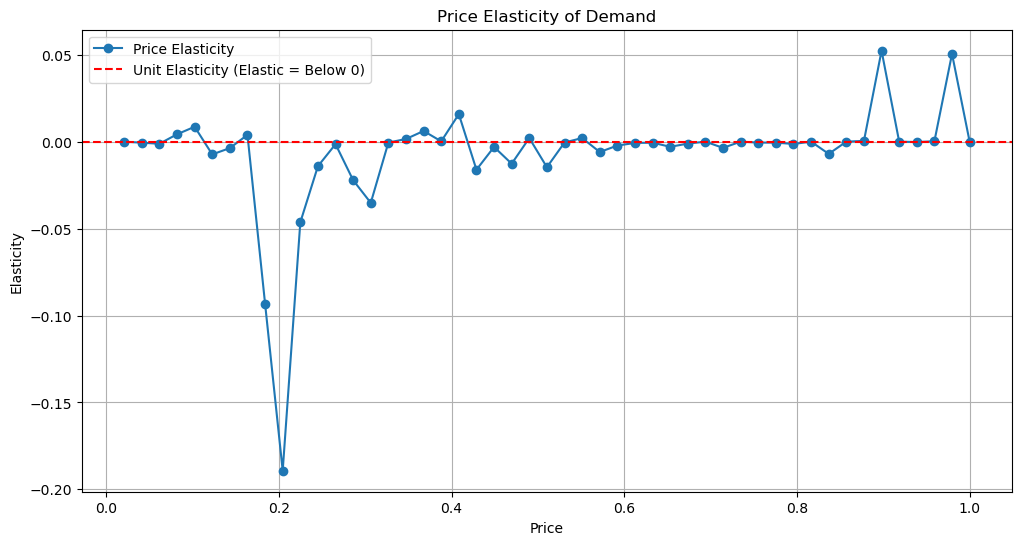

In [21]:
# Price Elasticity and Impact on Demand

# Estimate price elasticity by calculating the percentage change in quantity sold for percentage changes in unit price.

# Define price elasticity calculation
def calculate_price_elasticity(price_range, simulated_revenue):
    prices, revenues = zip(*simulated_revenue)
    quantities = [revenue / price for price, revenue in simulated_revenue if price > 0]  # Avoid division by zero

    # Calculate percentage changes in price and quantity
    price_changes = np.diff(prices) / prices[:-1]
    quantity_changes = np.diff(quantities) / quantities[:-1]

    # Compute elasticity
    elasticity = quantity_changes / price_changes
    return prices[1:], elasticity  # Skip the first price as diff reduces array size

# Calculate elasticity
prices, elasticity = calculate_price_elasticity(price_range, simulated_revenue)

# Visualize elasticity
plt.figure(figsize=(12, 6))
plt.plot(prices, elasticity, marker='o', label="Price Elasticity")
plt.axhline(0, color='red', linestyle='--', label="Unit Elasticity (Elastic = Below 0)")
plt.title("Price Elasticity of Demand")
plt.xlabel("Price")
plt.ylabel("Elasticity")
plt.legend()
plt.grid(True)
plt.show()

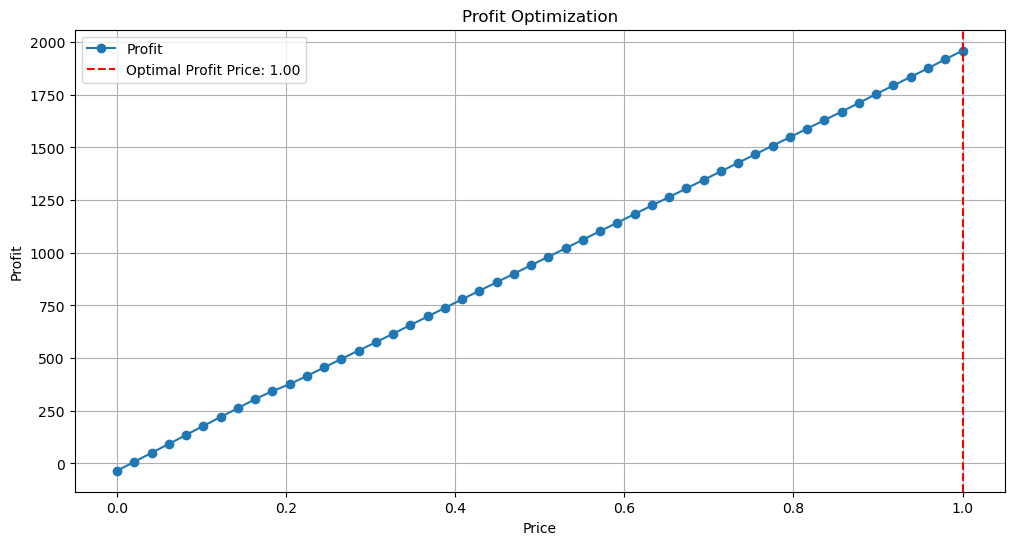


Optimal Profit Price: 1.00
Maximum Profit: 1959.46


In [22]:
# Optimal Pricing Strategies for Maximizing Revenue

# Simulations have already identified the revenue-maximizing price point. To add depth, assess profit by incorporating costs.

# Calculate profit for each price point
simulated_profit = [(price, revenue - (data['freight_price'].mean() * len(y_test))) for price, revenue in simulated_revenue]

# Find the price that maximizes profit
optimal_profit_price = max(simulated_profit, key=lambda x: x[1])

# Visualize profit vs price
prices, profits = zip(*simulated_profit)
plt.figure(figsize=(12, 6))
plt.plot(prices, profits, marker='o', label="Profit")
plt.axvline(optimal_profit_price[0], color='red', linestyle='--', label=f"Optimal Profit Price: {optimal_profit_price[0]:.2f}")
plt.title("Profit Optimization")
plt.xlabel("Price")
plt.ylabel("Profit")
plt.legend()
plt.grid(True)
plt.show()

# Output optimal price and profit
print(f"\nOptimal Profit Price: {optimal_profit_price[0]:.2f}")
print(f"Maximum Profit: {optimal_profit_price[1]:.2f}")

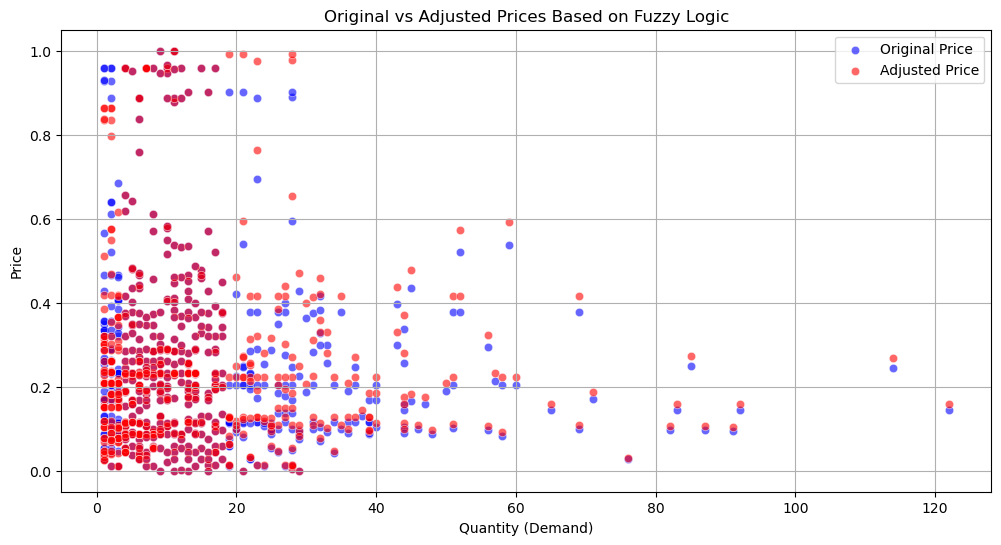

In [23]:
# Enhancing Pricing Decisions with Advanced Techniques
# Explore the use of utility optimization and fuzzy logic for pricing adjustments.

# Utility Optimization
# The earlier utility optimization already demonstrates this technique. You’ve successfully used it to determine the price that maximizes the difference between price and cost.

# Fuzzy Logic Pricing Adjustment
# Use fuzzy rules to adjust prices dynamically based on demand thresholds.

# Define demand thresholds
high_demand_threshold = np.percentile(data['qty'], 75)
low_demand_threshold = np.percentile(data['qty'], 25)

# Apply fuzzy logic for price adjustment
def fuzzy_logic_price_adjustment(price, demand):
    if demand > high_demand_threshold:  # High demand
        return price * 1.1  # Increase price by 10%
    elif demand < low_demand_threshold:  # Low demand
        return price * 0.9  # Decrease price by 10%
    else:
        return price  # No adjustment

data['adjusted_price'] = data.apply(lambda row: fuzzy_logic_price_adjustment(row['unit_price'], row['qty']), axis=1)

# Visualize original vs adjusted prices
plt.figure(figsize=(12, 6))
sns.scatterplot(x='qty', y='unit_price', data=data, label='Original Price', color='blue', alpha=0.6)
sns.scatterplot(x='qty', y='adjusted_price', data=data, label='Adjusted Price', color='red', alpha=0.6)
plt.title("Original vs Adjusted Prices Based on Fuzzy Logic")
plt.xlabel("Quantity (Demand)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


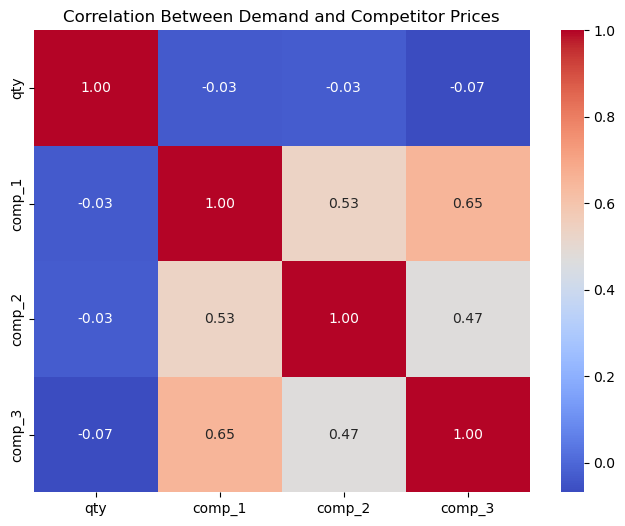

In [25]:
# Competitor Prices and Customer Segmentation in Dynamic Pricing
# Incorporate competitor prices and segment customers for dynamic pricing strategies.

# Competitor Prices
# Visualize and analyze how competitor prices affect demand.

# Correlation between competitor prices and demand
competitor_features = ['comp_1', 'comp_2', 'comp_3']
correlations = data[['qty'] + competitor_features].corr()

# Visualize correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Demand and Competitor Prices")
plt.show()


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


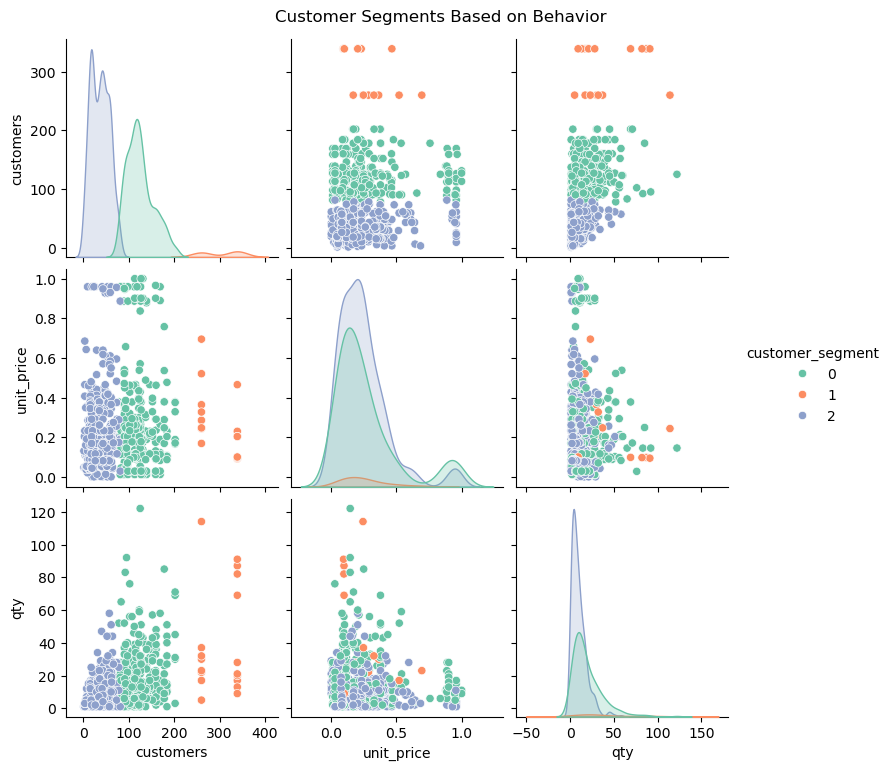

In [26]:
# Customer Segmentation
# Cluster customers based on their purchase behavior for targeted pricing strategies.

from sklearn.cluster import KMeans

# Use customer behavior features for clustering
customer_features = ['customers', 'unit_price', 'qty']
kmeans = KMeans(n_clusters=3, random_state=42)
data['customer_segment'] = kmeans.fit_predict(data[customer_features])

# Visualize customer segments
sns.pairplot(data, hue='customer_segment', vars=customer_features, palette="Set2")
plt.suptitle("Customer Segments Based on Behavior", y=1.02)
plt.show()